In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df =pd.read_csv('adult.csv' , na_values='?' ,encoding='latin1')

In [3]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.shape

(32561, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

<Axes: >

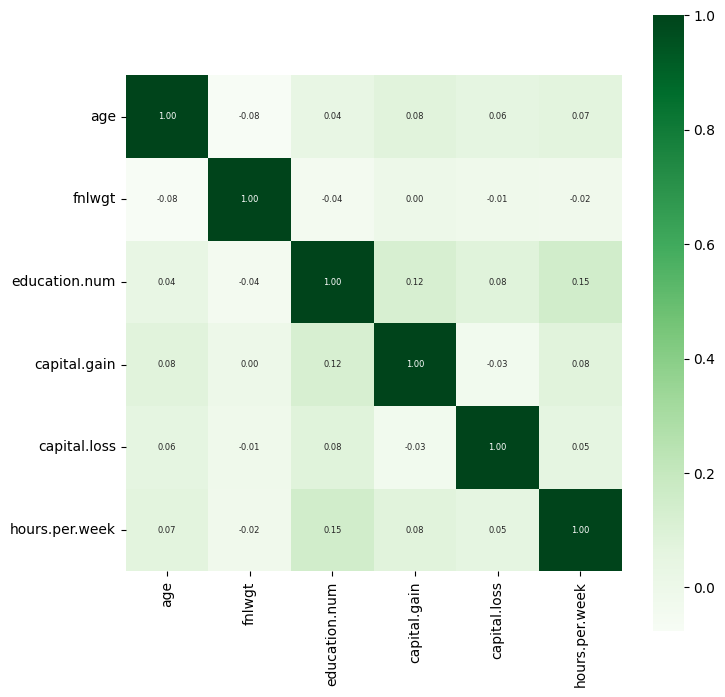

In [56]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
# numeric_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(numeric_df.corr() , annot=True , cmap='Greens'  , square=True , fmt='.2f' ,cbar=True ,
            annot_kws={'size':6})

## Data Preprocessing

In [7]:
cat_cols=[]
low_card_cols=[]
high_card_cols=[]
for col in df.columns:
  if(df[col].dtype=='object'):
    cat_cols.append(col)
    if(df[col].nunique()<=5):
      low_card_cols.append(col)
    else:
      high_card_cols.append(col)

for i in range(len(cat_cols)):
  print(cat_cols[i] , df[cat_cols[i]].nunique())
low_card_cols.remove('income')

workclass 8
education 16
marital.status 7
occupation 14
relationship 6
race 5
sex 2
native.country 41
income 2


In [8]:
df['native.country'].value_counts()

native.country
United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                           29
France       

There's is an imbalance in native.country column , with around 89.6% entries having same value United-States. More over there are many uniques values in it , which makes it difficult to encode.We will drop this column for now.

In [9]:
df.drop('native.country' , axis='columns' , inplace=True)

In [10]:
nominal_cols=high_card_cols
nominal_cols.remove('education')
nominal_cols.remove('native.country')

In [11]:
ordinal_cols=['education']

In [12]:
df.drop(24917 , axis=0 , inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
X=df.drop('income' , axis='columns')
y=df['income']
X_train , X_test ,y_train , y_test =train_test_split(X , y, test_size=0.2 , random_state=42)

In columns like education ordering matters because a particular level is higher /lower than other.So we will go for ordinal encoding

For others with low cardinality one hot encoding is feasible.

But for columns with high cardinality we just label encode the columns

In [14]:
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder , OneHotEncoder
label=LabelEncoder()
ordinal=OrdinalEncoder()
oneHot=OneHotEncoder(sparse=False , drop='first')

X_train_scaled=X_train
X_train_scaled[ordinal_cols]=ordinal.fit_transform(X_train[ordinal_cols])
X_test_scaled=X_test
X_test_scaled[ordinal_cols]=ordinal.transform(X_test[ordinal_cols])
for col in nominal_cols:
  X_train_scaled[col]=label.fit_transform(X_train_scaled[col])
  X_test_scaled[col]=label.transform(X_test_scaled[col])

X_train_encoded=oneHot.fit_transform(X_train_scaled[low_card_cols])
X_train_df=pd.DataFrame(X_train_encoded ,columns=oneHot.get_feature_names_out(low_card_cols))
X_train_final = X_train_scaled.drop(columns=low_card_cols).reset_index(drop=True)
X_train_final = pd.concat([X_train_final, X_train_df], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
X_test_encoded=oneHot.transform(X_test_scaled[low_card_cols])
X_test_df=pd.DataFrame(X_test_encoded ,columns=oneHot.get_feature_names_out(low_card_cols))
X_test_final = X_test_scaled.drop(columns=low_card_cols).reset_index(drop=True)
X_test_final = pd.concat([X_test_final, X_test_df], axis='columns')

In [16]:
X_train=X_train_final
X_test=X_test_final

In [17]:
X_train.dropna(inplace=True)
# Just one row , hours per week is missing

In [18]:
label=LabelEncoder()
y_train=label.fit_transform(y_train)
y_test=label.transform(y_test)

## Decision Trees

In [55]:

accuracy_dict={}
f1_scores={}
roc_auc_scores={}

We create dictionaries to store scores of different models , this will help us to conclude which model performs well.

In [20]:

from sklearn.metrics import accuracy_score , confusion_matrix , classification_report , f1_score ,roc_auc_score
def evaluate_model(model):
  y_pred=model.predict(X_test)
  y_prob=model.predict_proba(X_test)[: , 1]
  y_pred_train=model.predict(X_train)
  clf_report = pd.DataFrame(classification_report(y_test , y_pred ,output_dict=True ))
  print(f"Accuracy Score Test: {accuracy_score(y_test, y_pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"Accuracy Score Train: {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  cm=confusion_matrix(y_test, y_pred)
  sns.heatmap(cm ,annot=True , cbar=False , yticklabels=False)
  acc=accuracy_score(y_test, y_pred) * 100
  f1=f1_score(y_test , y_pred)*100
  roc_auc=roc_auc_score(y_test , y_prob)*100
  return acc , f1 , roc_auc

In [21]:
from sklearn.tree import DecisionTreeClassifier
tree_clf=DecisionTreeClassifier(random_state=0)
tree_clf.fit(X_train , y_train)

DecisionTreeClassifier(random_state=0)

Accuracy Score Test: 80.84%
_______________________________________________
Accuracy Score Train: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.877758     0.590070  0.808354     0.733914      0.810121
recall        0.870709     0.605487  0.808354     0.738098      0.808354
f1-score      0.874219     0.597679  0.808354     0.735949      0.809203
support    4981.000000  1531.000000  0.808354  6512.000000   6512.000000
_______________________________________________


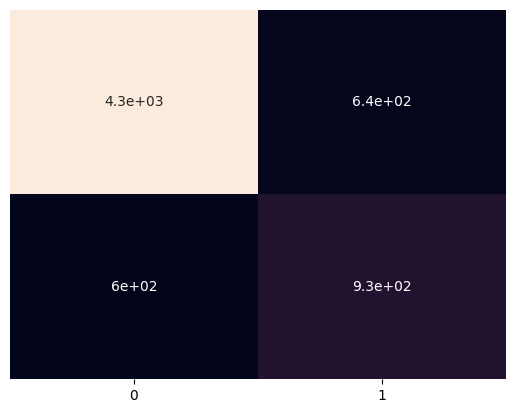

In [22]:
acc , f1 , roc_auc=evaluate_model(tree_clf)
accuracy_dict['Tree']=acc
f1_scores['Tree']=f1
roc_auc_scores['Tree']=roc_auc

##Decision Tree Hyper Parameter Tuning


In [23]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

params={
    "criterion":['gini' , 'entropy'], #function used to check the quality of split
    "splitter":['best', 'random'], #strategy used for splitting
    "max_depth":list(range(1,20)), # max depth of the tree
    # default = None
    "min_samples_split":[2,3,4],
    "min_samples_leaf":list(range(1,20)),
}

tree_clf=DecisionTreeClassifier(random_state=0)
tree_cv=GridSearchCV(
    tree_clf ,
    params ,
    scoring='f1',
    cv=5,
    verbose=1
)

tree_cv.fit(X_train , y_train)
best_parameters=tree_cv.best_params_
print(f"Best paramters: {best_parameters})")

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best paramters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 2, 'splitter': 'best'})


Accuracy Score Test: 85.43%
_______________________________________________
Accuracy Score Train: 86.54%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.881963     0.735818  0.854269     0.808891      0.847604
recall        0.934551     0.593076  0.854269     0.763814      0.854269
f1-score      0.907496     0.656781  0.854269     0.782139      0.848552
support    4981.000000  1531.000000  0.854269  6512.000000   6512.000000
_______________________________________________


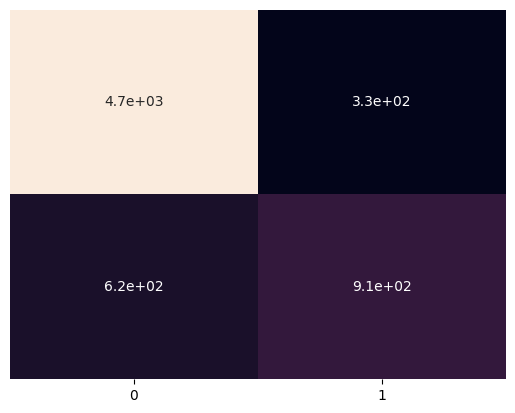

In [24]:
tree_clf_tuned=DecisionTreeClassifier(**best_parameters)
tree_clf_tuned.fit(X_train , y_train)
acc , f1 , roc_auc=evaluate_model(tree_clf_tuned)
accuracy_dict['Tree_tuned']=acc
f1_scores['Tree_tuned']=f1
roc_auc_scores['Tree_tuned']=roc_auc

# Parameter tuning helped us to reduce overfitting

## RandomForestClassifier

Accuracy Score Test: 85.04%
_______________________________________________
Accuracy Score Train: 99.99%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.884180     0.714726   0.85043     0.799453      0.844341
recall        0.925718     0.605487   0.85043     0.765602      0.850430
f1-score      0.904472     0.655587   0.85043     0.780030      0.845958
support    4981.000000  1531.000000   0.85043  6512.000000   6512.000000
_______________________________________________


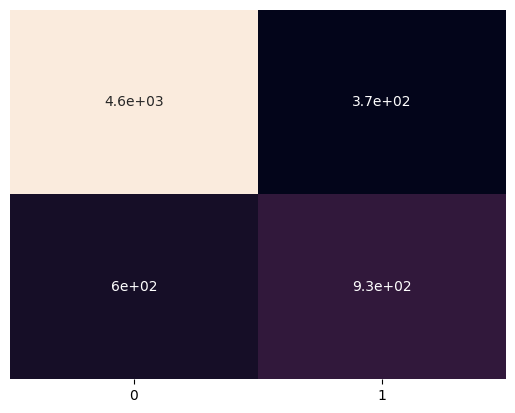

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=100 ,random_state=0)
rf_clf.fit(X_train,y_train)
acc , f1 , roc_auc=evaluate_model(rf_clf)
accuracy_dict['RandomForest']=acc
f1_scores['RandomForest']=f1
roc_auc_scores['RandomForest']=roc_auc

## RandomForest Hyperparameter tuning

In [26]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params_grid = {
    'n_estimators': [100, 500, 1000],
    # No of trees
    'max_features': ['log2', 'sqrt'],
    'max_depth': [2, 5 , None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'bootstrap': [True, False]
    # decides whether to use a bootstraped sample for training, generating a tree or to use entire dataset
}

rf_clf=RandomForestClassifier(random_state=0)
rf_cv=RandomizedSearchCV(
    rf_clf ,
    params_grid ,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=1,
)

rf_cv.fit(X_train , y_train)
best_params_rf=rf_cv.best_params_
print(f"Best parameters: {best_params_rf}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


Accuracy Score Test: 86.12%
_______________________________________________
Accuracy Score Train: 94.17%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.886445     0.753436  0.861179     0.819941      0.855174
recall        0.938767     0.608752  0.861179     0.773760      0.861179
f1-score      0.911856     0.673410  0.861179     0.792633      0.855797
support    4981.000000  1531.000000  0.861179  6512.000000   6512.000000
_______________________________________________


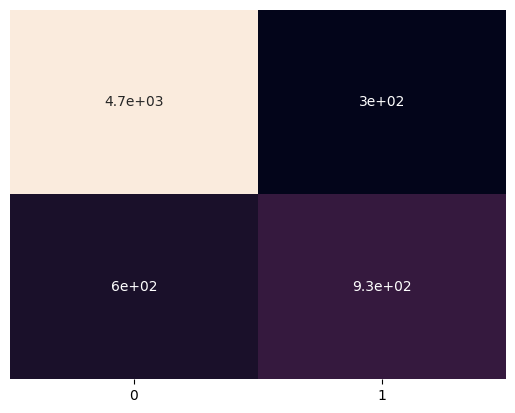

In [27]:
rf_clf_tuned = RandomForestClassifier(**best_params_rf,random_state=0)
rf_clf_tuned.fit(X_train, y_train)
acc , f1 , roc_auc=evaluate_model(rf_clf_tuned)
accuracy_dict['RF-Tuned']=acc
f1_scores['RF-Tuned']=f1
roc_auc_scores['RF-Tuned']=roc_auc

## Boosting Techniques

a) XGBoost

Accuracy Score Test: 86.89%
_______________________________________________
Accuracy Score Train: 90.83%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.896141     0.759785  0.868857     0.827963      0.864083
recall        0.937161     0.646636  0.868857     0.791899      0.868857
f1-score      0.916192     0.698659  0.868857     0.807426      0.865049
support    4981.000000  1531.000000  0.868857  6512.000000   6512.000000
_______________________________________________


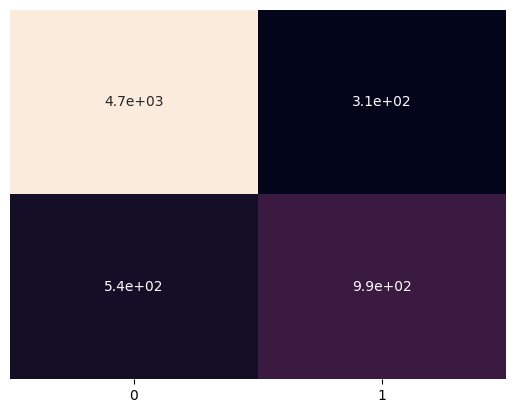

In [28]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier(random_state=0)
xgb_model.fit(X_train , y_train)
acc, f1 , roc_auc=evaluate_model(xgb_model)
accuracy_dict['xgb']=acc
f1_scores['xgb']=f1
roc_auc_scores['xgb']=roc_auc

Accuracy Score Test: 86.79%
_______________________________________________
Accuracy Score Train: 91.83%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.896174     0.755912  0.867936     0.826043      0.863198
recall        0.935756     0.647289  0.867936     0.791523      0.867936
f1-score      0.915537     0.697396  0.867936     0.806467      0.864251
support    4981.000000  1531.000000  0.867936  6512.000000   6512.000000
_______________________________________________


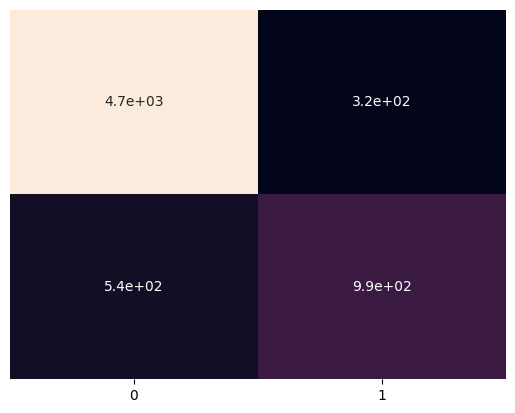

In [29]:
# Parameter tuning
xgb_model_tuned=XGBClassifier(n_estimators=1000, learning_rate=0.05 ,random_state=0)
xgb_model_tuned.fit(X_train , y_train)
acc ,f1, roc_auc=evaluate_model(xgb_model_tuned)
accuracy_dict['xgb_tuned']=acc
f1_scores['xgb_tuned']=f1
roc_auc_scores['xgb_tuned']=roc_auc

In [30]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## b) LightGBM

Accuracy Score Test: 87.22%
_______________________________________________
Accuracy Score Train: 89.04%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.894467     0.778931  0.872236     0.836699      0.867304
recall        0.944389     0.637492  0.872236     0.790940      0.872236
f1-score      0.918750     0.701149  0.872236     0.809950      0.867591
support    4981.000000  1531.000000  0.872236  6512.000000   6512.000000
_______________________________________________


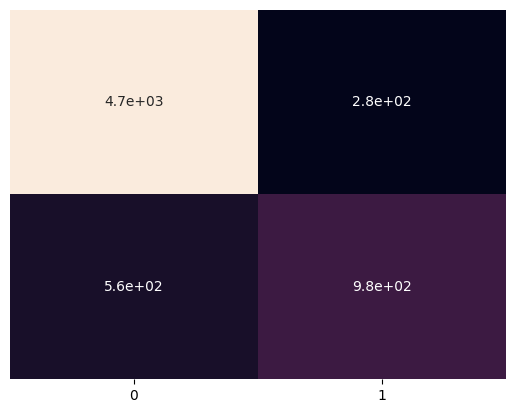

In [31]:
import lightgbm as lgb
lgb_clf=lgb.LGBMClassifier(random_state=0,verbose=-1)
lgb_clf.fit(X_train , y_train)
acc , f1 , roc_auc=evaluate_model(lgb_clf)
accuracy_dict['lgb']=acc
f1_scores['lgb']=f1
roc_auc_scores['lgb']=roc_auc

Accuracy Score Test: 86.69%
_______________________________________________
Accuracy Score Train: 93.63%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.894818     0.754992  0.866861     0.824905      0.861944
recall        0.935957     0.642064  0.866861     0.789010      0.866861
f1-score      0.914925     0.693964  0.866861     0.804444      0.862976
support    4981.000000  1531.000000  0.866861  6512.000000   6512.000000
_______________________________________________


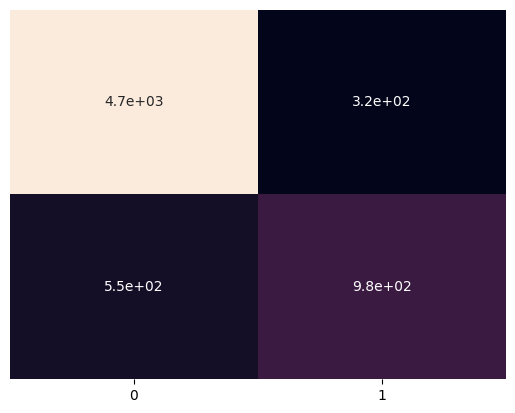

In [32]:
params={
    'learning_rate':0.05,
     'num_boost_round':1000,
}

lgb_clf_tuned=lgb.LGBMClassifier(**params,random_state=0 , verbose=-1)
lgb_clf_tuned.fit(X_train , y_train)

acc , f1 , roc_auc=evaluate_model(lgb_clf_tuned)
accuracy_dict['lgb_tuned']=acc
f1_scores['lgb_tuned']=f1
roc_auc_scores['lgb_tuned']=roc_auc

## c) Adaboost

Accuracy Score Test: 79.55%
_______________________________________________
Accuracy Score Train: 79.04%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.789282     0.985366  0.795455     0.887324      0.835382
recall        0.999398     0.131940  0.795455     0.565669      0.795455
f1-score      0.881999     0.232719  0.795455     0.557359      0.729350
support    4981.000000  1531.000000  0.795455  6512.000000   6512.000000
_______________________________________________


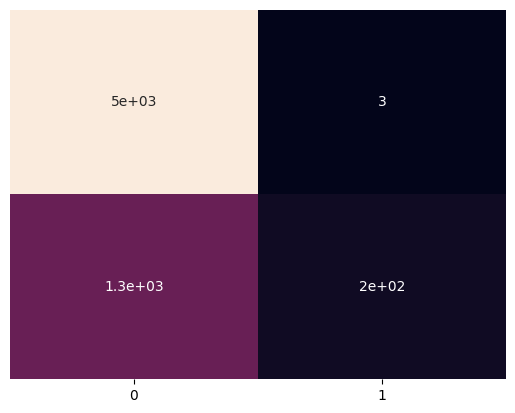

In [33]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100 , learning_rate=0.01 ,random_state=0)
ada_clf=abc.fit(X_train  , y_train)
acc , f1 , roc=evaluate_model(ada_clf)
accuracy_dict['Adaboost']=acc
f1_scores['Adaboost']=f1
roc_auc_scores['Adaboost']=roc_auc

## KNN

In [35]:
# Scaling values
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn=KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2 )
clf_knn.fit(X_train , y_train)

KNeighborsClassifier()

Accuracy Score Test: 82.69%
_______________________________________________
Accuracy Score Train: 87.83%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.873160     0.649852  0.826935     0.761506      0.820659
recall        0.905240     0.572175  0.826935     0.738707      0.826935
f1-score      0.888911     0.608545  0.826935     0.748728      0.822995
support    4981.000000  1531.000000  0.826935  6512.000000   6512.000000
_______________________________________________


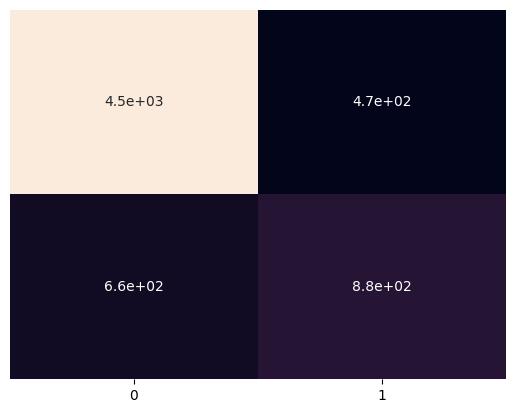

In [37]:
acc , f1 , roc_auc=evaluate_model(clf_knn)
accuracy_dict['knn']=acc
f1_scores['knn']=f1
roc_auc_scores['knn']=roc_auc

In [51]:
def evaluate_metric_diff_models(metric_dict):
  sorted_metric_dict=dict(sorted(metric_dict.items(), key=lambda item: item[1], reverse=True))
  keys = list(sorted_metric_dict.keys())
  values = list(sorted_metric_dict.values())
  df = pd.DataFrame({'Keys': keys, 'Values': values})

  # Create the bar plot
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Keys', y='Values', data=df , palette='mako')
  plt.xlabel('Different Models')
  plt.xticks(rotation=45)
  plt.ylabel('Values')
  plt.title('Histogram from Highest to Lowest Values')
  print(keys[0], values[0])
  plt.show()

lgb 87.22358722358723


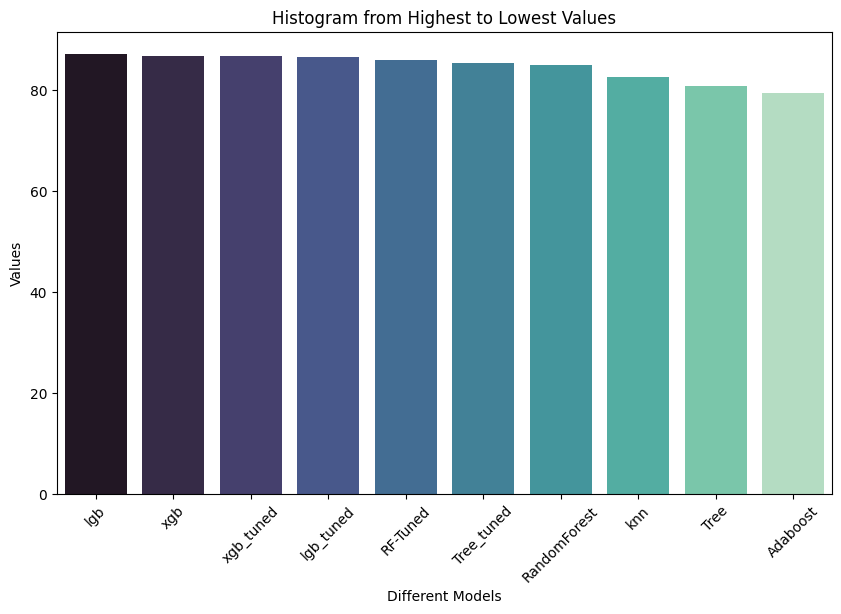

In [52]:
evaluate_metric_diff_models(accuracy_dict)

lgb 70.11494252873564


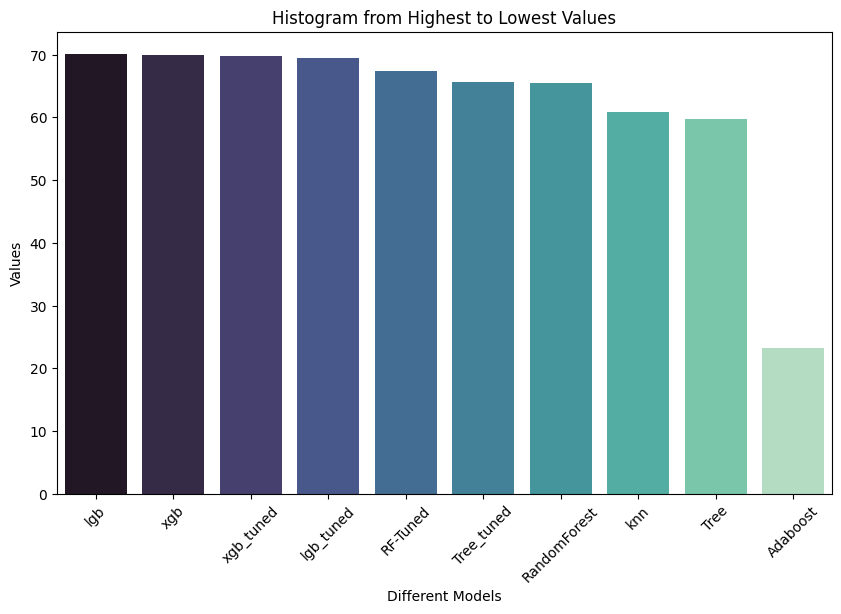

In [53]:
evaluate_metric_diff_models(f1_scores)

lgb 92.61625266804188


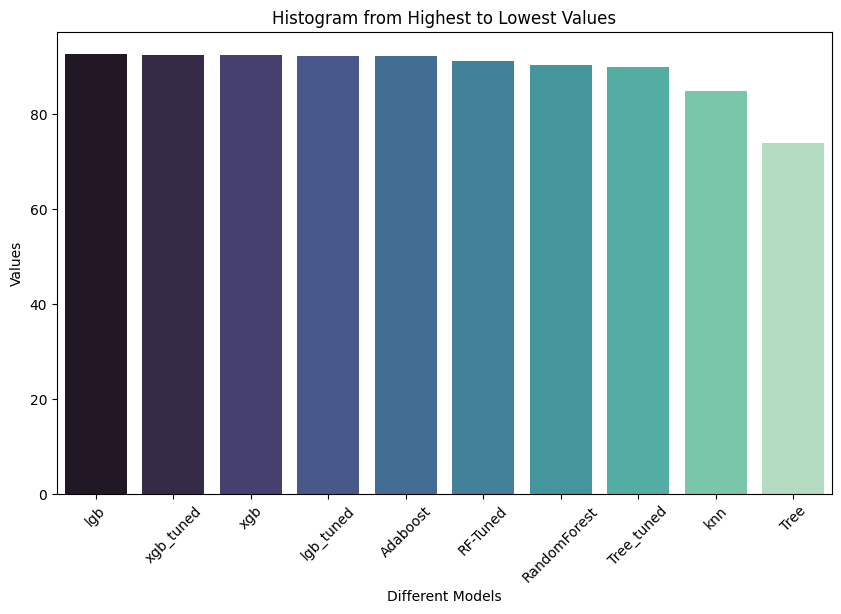

In [54]:
evaluate_metric_diff_models(roc_auc_scores)

# roc_auc_score for lgb is 0.92 close to 1
# Its distinguishes classes well

From the above graphs its quite clear that lgb perform really good on Adult dataset, Same is the case with xgb
With large datasets like adult adaboost and decision tree turn out to be less effective.